# Reinforcement Learning algorithm

In [383]:
import copy
import csv
import random

import matplotlib.pyplot as plt
import numpy as np

import ambulance_game as abg

from utility_functions import *

## Hospital 1

- Resources:
  - System capacity: $N = 35$
  - Buffer capacity: $M = 20$ 
  - Num of servers: $C = 10$

- Overall arrival rate: $\Lambda = \frac{1}{92} × C$ 
   - $\lambda_1 = \lambda_2 = \frac{\Lambda}{2}$

- Threshold: $T = 15$
- Target: $t = 4$

In [2]:
# Drawn from Parametrisation.ipynb
system_capacity = 35
buffer_capacity = 20
num_of_servers = 10

In [3]:
arrival_rate = (1 / 92) * num_of_servers
ambulance_proportion = 0.5

lambda_2 = arrival_rate * ambulance_proportion
lambda_1 = arrival_rate * (1 - ambulance_proportion)

In [4]:
threshold = 15
target = 4

- Service rates: 
  - **Initial service rate:** $s = \frac{1}{86}$ 
  - **Speedy service rate:** $s = \frac{1}{62}$
  - **Fatigue service rate:** $s = \frac{1}{75}$

$$
  s(u, v) = 
  \begin{cases}
    \frac{1}{86}, \text{ if } u + v < 7 \\
    \frac{1}{62}, \text{ if } 8 < u + v < 15 \\
    \frac{1}{75}, \text{ otherwise }
  \end{cases}
$$

In [5]:
service_rate_initial = 1 / 86
service_rate_speed = 1 / 62
service_rate_fatigue = 1 / 75

In [6]:
def get_base_service_rate(u, v):
    """
    Find the base service rate for all servers for a given state.
    """
    if u + v < 7:
        return service_rate_initial
    elif u + v < 15:
        return service_rate_speed
    else:
        return service_rate_fatigue

- Service rates for each server: $\mu_k^{(u,v)} = s(u, v) \times r$ where: 
  - $k \in [1, C]$
  - $r$ is a random number that is fixed for each server

In [7]:
def build_specific_service_rates(
    num_of_servers, system_capacity, buffer_capacity, rand_range=(1, 1)
):
    """
    Get the custom service rates for this particular problem
    """
    rates = {}
    for server in range(1, num_of_servers + 1):
        rates[server] = {}
        random_effect = random.uniform(*rand_range)
        for u in range(buffer_capacity + 1):
            for v in range(system_capacity + 1):
                base_service_rate = get_base_service_rate(u, v)
                rates[server][(u, v)] = (
                    (base_service_rate) * random_effect
                )
    return rates

In [392]:
random.seed(0)
rates = build_specific_service_rates(
    num_of_servers, system_capacity, buffer_capacity, rand_range=(1, 1.5),
)

## Simulation

In [393]:
def random_prioirity(srv, ind):
    return random.random()

Q = abg.simulation.simulate_model(
    lambda_1=lambda_1, 
    lambda_2=lambda_2, 
    mu=rates, 
    num_of_servers=num_of_servers, 
    threshold=threshold, 
    system_capacity=system_capacity, 
    buffer_capacity=buffer_capacity,
    runtime=200000,
    num_of_trials=1,
    seed_num=0,
    server_priority_function=random_prioirity,
)

## Explored states

In [394]:
print("Max inds in parking:", max(Q.statetracker.state_probabilities(), key=lambda x: x[0])[0])
print("Max inds in hospital:", max(Q.statetracker.state_probabilities(), key=lambda x: x[1])[1])

Max inds in parking: 10
Max inds in hospital: 19


## Utility functions
Weighted averages of all possible pairs of:
- individuals served
- idle time
- service time/rate
$$
    U_k^1 = e (\text{\# served}) + (1-e) (\text{idle time})
$$
$$
    U_k^2 = e \frac{\text{\# served}}{\text{\# all individuals}} + (1 - e) \frac{\text{current time - busy time}}{\text{current time}}
$$
$$
    U_k^3 = e (\text{mean service time})_k + (1 - e) (\text{idle time})_k
$$
$$
    U_k^4 = e (\frac{1}{\text{mean service time}_k}) + (1 - e) (\text{idle time})_k
$$
$$
    U_k^5 = e \frac{\text{\# served}}{\text{\# all individuals}} + (1 - e) (\text{mean service time})_k
$$
$$
    U_k^6 = e \frac{\text{\# served}}{\text{\# all individuals}} + (1 - e) (\frac{1}{\text{mean service time}_k})
$$

In [415]:
print("SERVER ID \tUTIL.3 \tSERVED \t% BUSY \tMEAN SERVICE")
for srv in Q.nodes[2].servers:
    print(
        f"Server {srv.id_number}:" +
        f"\t{round(utility_function_4([Q], srv.id_number, 0.2), 3)}" + 
        f"\t{len(srv.served_inds)}" +
        f"\t{round(100 * srv.busy_time / Q.current_time, 3)}" +
        f"\t{round(np.mean(srv.service_times), 6)}"
    )

SERVER ID 	UTIL.3 	SERVED 	% BUSY 	MEAN SERVICE
Server 1:	0.306	2294	62.269	54.425735
Server 2:	0.305	2284	62.311	54.564329
Server 3:	0.283	2090	65.083	62.308002
Server 4:	0.276	1987	65.918	66.350343
Server 5:	0.301	2194	62.761	57.212813
Server 6:	0.275	2027	65.952	65.074807
Server 7:	0.297	2278	63.297	55.573839
Server 8:	0.265	2031	67.214	66.189285
Server 9:	0.275	2119	65.97	62.297274
Server 10:	0.295	2249	63.55	56.529589


# Reinforcement Learning algorithm

## Old implementation
- Initialise server-state rates
- Run initial simulation
- For a number of iterations:
  - Select a state $(u, v)$ **for every** server
  - Pick a policy server $k$ on state $(u, v)$
  - Run simulation
  - For $k$ in all servers:
    - If utility of server $k$ increased:
      - Accept new policy of server $k$
      - Update server utility of server $k$


## New implementation
- Initialise server-state rates
- Run initial simulation
- For a number of iterations:
  - Select a server $k$ and a state $(u, v)$
  - Pick a policy for server $k$ on state $(u, v)$
  - Run simulation with new policy
  - If new states are within range AND utility of server $k$ increased:
    - Accept the new policy
    - Update **ALL** server utilities to their new ones

In [341]:
def output_to_file(utilist, filename="demo.csv"):
    with open(filename, 'a') as f:
        f.write(utilist + '\n')

def read_from_file(filename):
    my_list = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            my_list.append([float(i[1:-1]) for i in row])
    return my_list

In [342]:
def pick_a_state(Q):
    """
    Pick a state to update.
    """
    all_states = Q.statetracker.state_probabilities()
    all_visited_states = [state for state in all_states if all_states[state] > 0]
    state = random.choice(all_visited_states)
    # print("Chosen state: ", state)
    return state

In [368]:
def pick_policy(Qs, rates, num_of_servers):
    """
    Pick a new policy for a single server.
    """
    Q = random.choice(Qs)
    srv = random.randint(1, num_of_servers)
    # print("Chosen server: ", srv)
    rates[srv][pick_a_state(Q)] *= random.uniform(0.5, 1.5)
    return rates, srv

In [369]:
def accept_policy(Qs, utility_function, e_parameter, server_utilities, current_server_id):
    """
    Accept or reject a policy.
    """
    # print(f"Old - new utilities server {current_server_id}: {server_utilities[current_server_id - 1]} - {utility_function(Qs, current_server_id, 0.1)}")
    condition = server_utilities[current_server_id - 1] <= utility_function(
        Qs, current_server_id, e_parameter
    )
    # print("Accept? ", condition)
    return condition


def are_within_limits(rates):
    """
    Check if the rates are within the limits.
    """
    for srv in rates:
        for state in rates[srv]:
            rate = rates[srv][state]
            if rate < 0.0001 or rate > 1:
                print(f"Rate {rate} out of bounds: Server {srv}, State {state}")
                return False
    # print("All rates within limits.")
    return True

In [422]:
def update_server_utilities(Qs, utility_function, e_parameter, num_of_servers):
    """
    Update the utilities of all servers.
    """
    new_utilities = [
        utility_function(Qs, srv_id, e_parameter) for srv_id in range(1, num_of_servers + 1)
    ]
    return new_utilities

In [371]:
def run_simulation(parameters, rates):
    Qs = abg.simulation.simulate_model(
        lambda_1=parameters["lambda_1"],
        lambda_2=parameters["lambda_2"],
        mu=rates,
        num_of_servers=parameters["num_of_servers"],
        threshold=parameters["threshold"],
        system_capacity=parameters["system_capacity"],
        buffer_capacity=parameters["buffer_capacity"],
        runtime=parameters["runtime"],
        num_of_trials=parameters["num_of_trials"],
        seed_num=parameters["seed_num"],
        server_priority_function=parameters["server_priority_function"],
    )
    if type(Qs) is not list:
        Qs = [Qs]
    return Qs

In [379]:
parameters = {
    "lambda_1": lambda_1,
    "lambda_2": lambda_2,
    "num_of_servers": num_of_servers,
    "threshold": threshold,
    "system_capacity": system_capacity,
    "buffer_capacity": buffer_capacity,
    "runtime": 10000,
    "num_of_trials": 10,
    "seed_num": 0,
    "server_priority_function": random_prioirity,
}

In [380]:
def random_prioirity(srv, ind):
    return random.random()

random.seed(0)
rates = build_specific_service_rates(num_of_servers, system_capacity, buffer_capacity)
initial_rates = copy.deepcopy(rates)
server_utilities = [-float("inf") for srv in range(1, parameters["num_of_servers"] + 1)]
num_of_iterations = 10000
current_utility_function = utility_function_3
e_parameter = 1
all_utilities, all_rates = [], []

In [381]:
Qs = run_simulation(parameters, initial_rates)
for _ in range(num_of_iterations):
    random.seed()
    new_rates, server_id = pick_policy(Qs, rates, num_of_servers)
    Qs = run_simulation(parameters, new_rates)
    # print("Within limits:", are_within_limits(new_rates))
    random.seed()
    if are_within_limits(new_rates) and accept_policy(
        Qs=Qs, 
        utility_function=current_utility_function, 
        e_parameter=e_parameter,
        server_utilities=server_utilities, 
        current_server_id=server_id
    ):
        server_utilities = update_server_utilities(
            Qs=Qs, 
            utility_function=current_utility_function, 
            e_parameter=e_parameter,
            num_of_servers=parameters["num_of_servers"]
        )
        rates = copy.deepcopy(new_rates)
    
    all_utilities.append(server_utilities.copy())
    all_rates.append(copy.deepcopy(rates))
    # output_to_file(str(server_utilities), "utilities_attempt_5.csv")
    # output_to_file(str(rates), "rates_attempt_5.csv")

    if iter % int(num_of_iterations / 10) == 0:
        print("Iteration:", iter)

Iteration: 0
Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000


## RL - only on Server 1

- e = 1
- $U_k^4 = e (\text{mean service time}_k) + (1 - e) (\text{idle time})_k$
- Outcome: Only Server 1, increases their utility and thus lowers their service rate

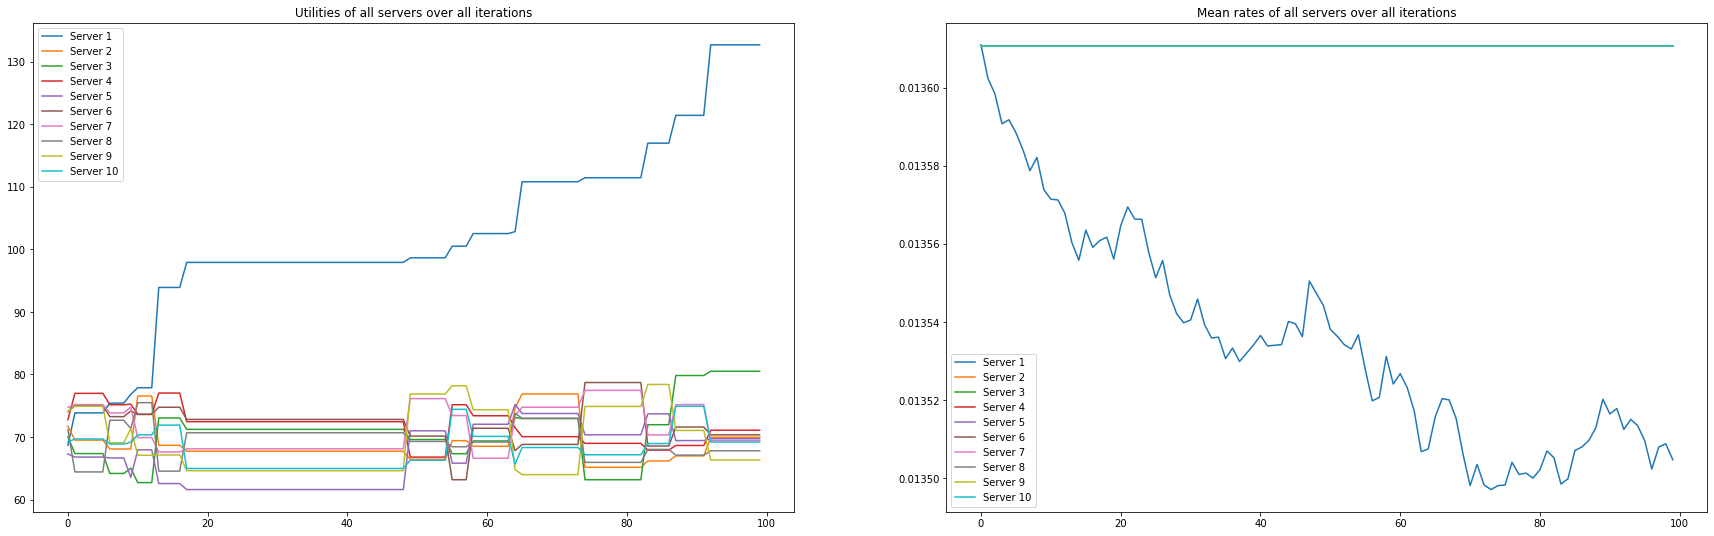

In [366]:
# plt.figure(figsize=(14, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
for srv in range(num_of_servers):
    ax1.plot([util[srv] for util in all_utilities])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title("Utilities of all servers over all iterations")

for srv in range(1, parameters["num_of_servers"] + 1):
    current_server_rate = [np.mean(list(rates[srv].values())[:-1]) for rates in all_rates]
    ax2.plot(current_server_rate)
    ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title("Mean rates of all servers over all iterations")
plt.show()

## Multiple servers

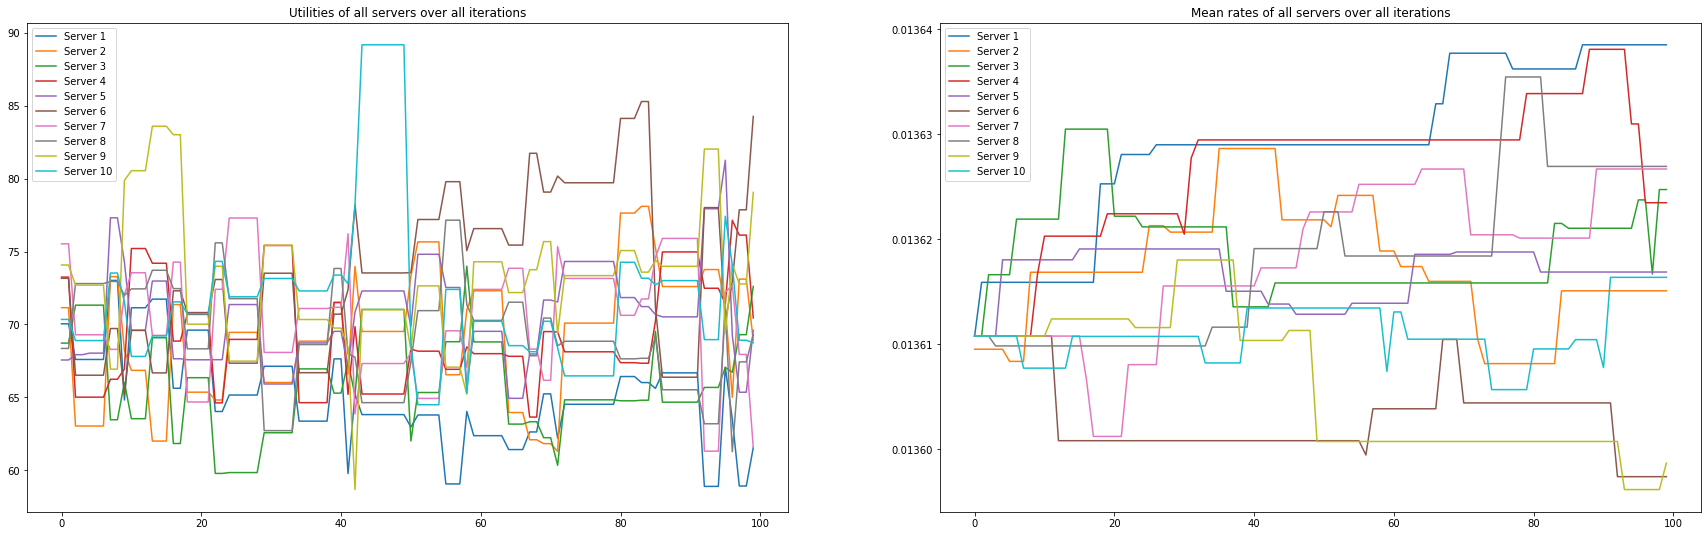

In [375]:
# plt.figure(figsize=(14, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
for srv in range(num_of_servers):
    ax1.plot([util[srv] for util in all_utilities])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title("Utilities of all servers over all iterations")

for srv in range(1, parameters["num_of_servers"] + 1):
    current_server_rate = [np.mean(list(rates[srv].values())[:-1]) for rates in all_rates]
    ax2.plot(current_server_rate)
    ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title("Mean rates of all servers over all iterations")
plt.show()

## Multiple servers - (num_of_trials = 10, iteration = 10000)

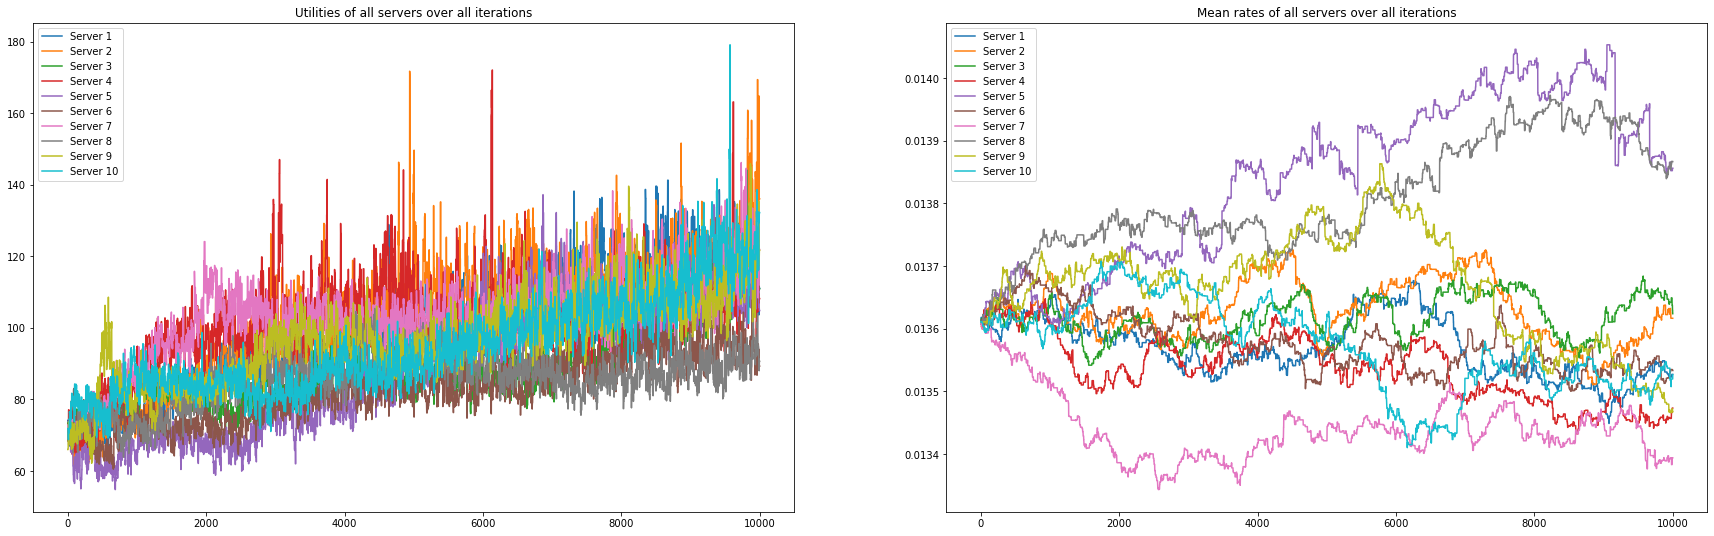

In [382]:
# plt.figure(figsize=(14, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
for srv in range(num_of_servers):
    ax1.plot([util[srv] for util in all_utilities])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title("Utilities of all servers over all iterations")

for srv in range(1, parameters["num_of_servers"] + 1):
    current_server_rate = [np.mean(list(rates[srv].values())[:-1]) for rates in all_rates]
    ax2.plot(current_server_rate)
    ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title("Mean rates of all servers over all iterations")
plt.show()

## 4th Attempt

- e = 0.9
- $U_k^4 = e (\frac{1}{\text{mean service time}_k}) + (1 - e) (\text{idle time})_k$
- Outcome: ??????

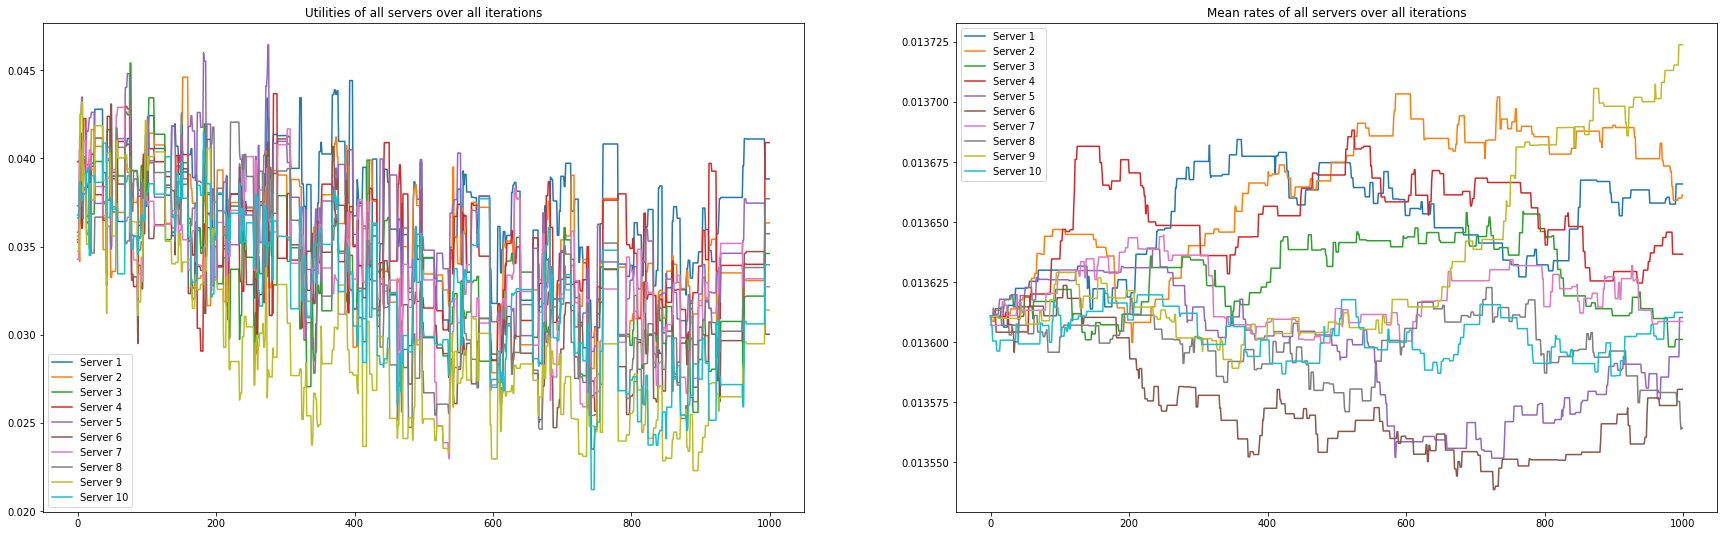

In [266]:
# plt.figure(figsize=(14, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
for srv in range(num_of_servers):
    ax1.plot([util[srv] for util in all_utilities])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title("Utilities of all servers over all iterations")

for srv in range(1, parameters["num_of_servers"] + 1):
    current_server_rate = [np.mean(list(rates[srv].values())[:-1]) for rates in all_rates]
    ax2.plot(current_server_rate)
    ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title("Mean rates of all servers over all iterations")
plt.show()

## 3rd Attempt

- e = 0.1
- $U_k^4 = e (\frac{1}{\text{mean service time}_k}) + (1 - e) (\text{idle time})_k$
- Outcome: ??????


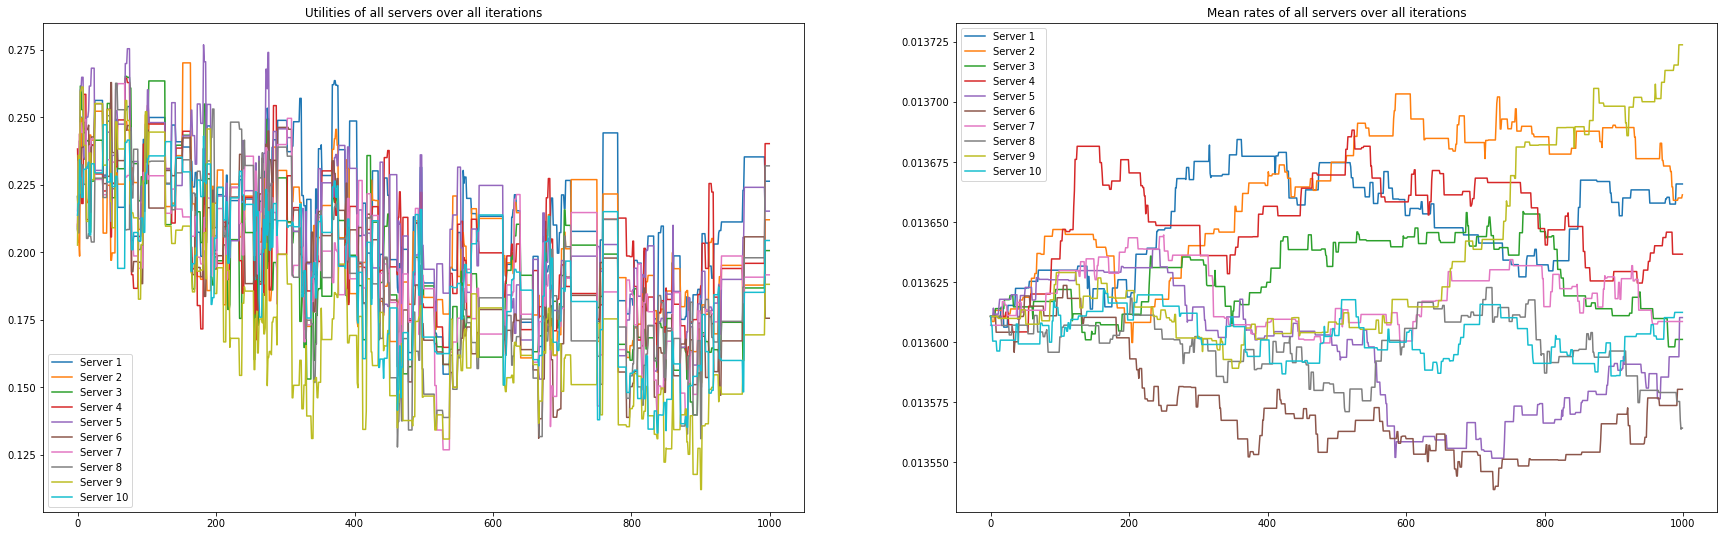

In [259]:
# plt.figure(figsize=(14, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 9))
for srv in range(num_of_servers):
    ax1.plot([util[srv] for util in all_utilities])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title("Utilities of all servers over all iterations")

for srv in range(1, parameters["num_of_servers"] + 1):
    current_server_rate = [np.mean(list(rates[srv].values())[:-1]) for rates in all_rates]
    ax2.plot(current_server_rate)
    ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title("Mean rates of all servers over all iterations")
plt.show()

## 2nd Attempt

- e = 0.5
- $U_k^3 = e (\text{mean service time})_k + (1 - e) (\text{idle time})_k$
- Outcome $\rightarrow$ Service rate increases

In [40]:
utilities_attempt_2 = read_from_file("utilities_attempt_2.csv")

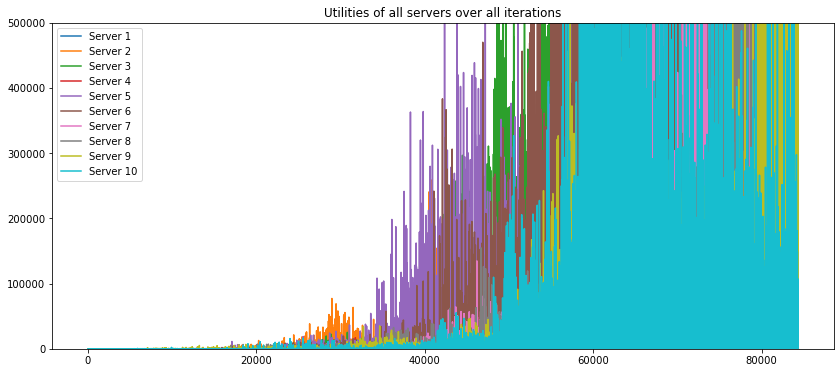

In [42]:
plt.figure(figsize=(14, 6))
for srv in range(num_of_servers):
    plt.plot([i[srv] for i in utilities_attempt_2])
plt.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
plt.title("Utilities of all servers over all iterations")
plt.ylim(0, 500000)
plt.show()

In [217]:
all_diff_rates = []
for srv_id in range(1, num_of_servers + 1):
    diff_rates = np.zeros((buffer_capacity + 1, system_capacity + 1))
    for (u, v) in initial_rates[srv_id].keys():
        diff_rates[u, v] = rates[srv_id][(u,v)] - initial_rates[srv_id][(u,v)]
    all_diff_rates.append(diff_rates)

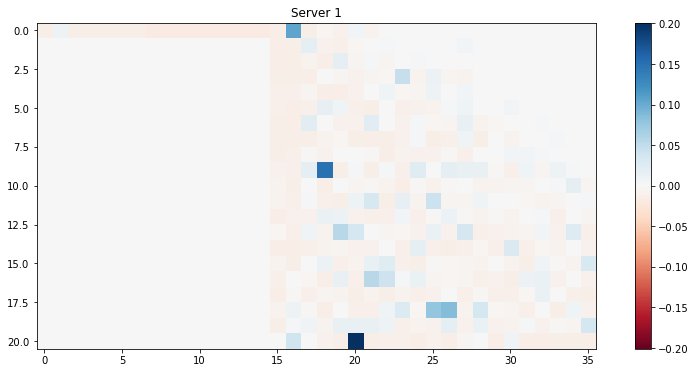

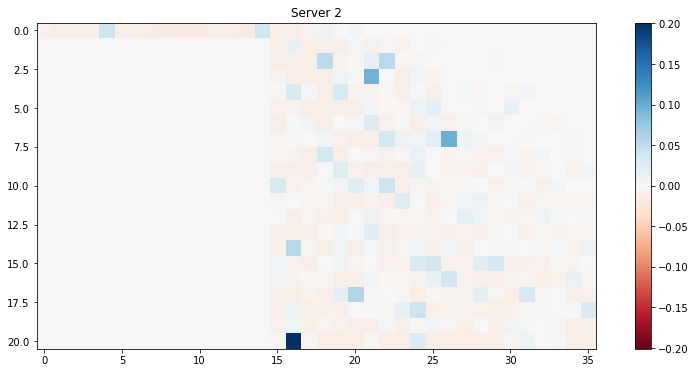

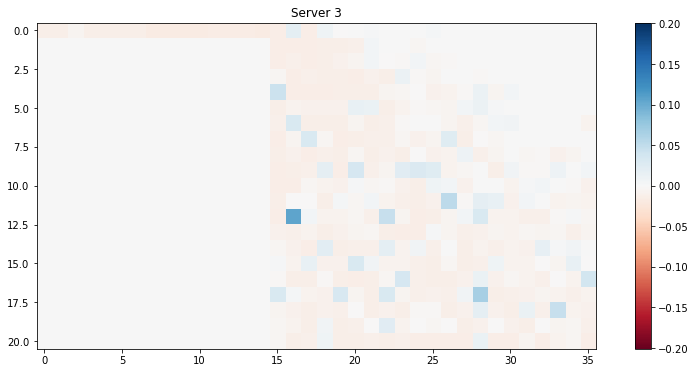

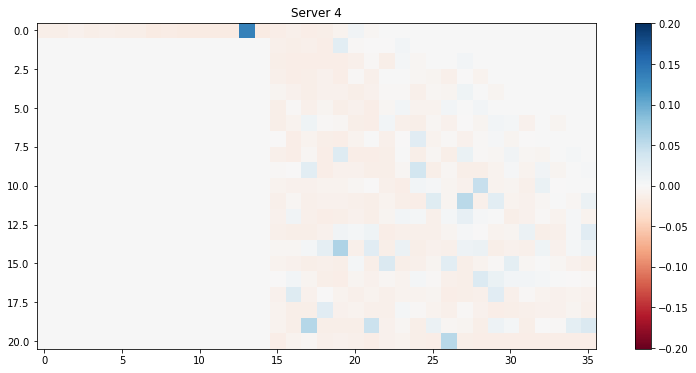

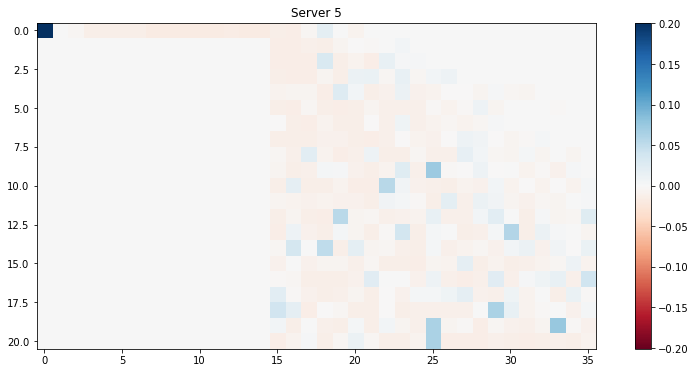

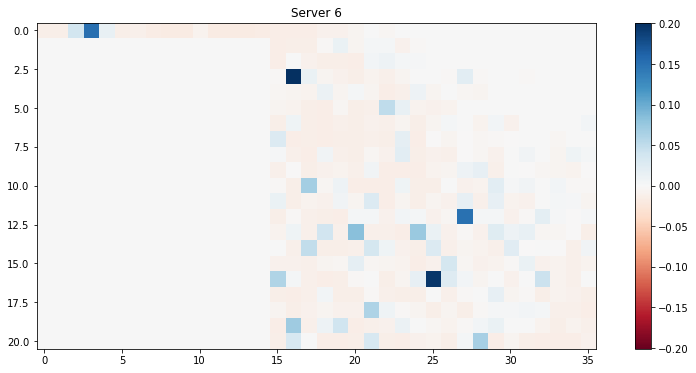

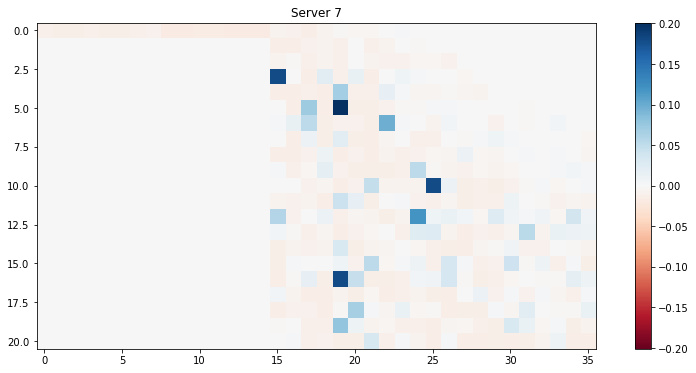

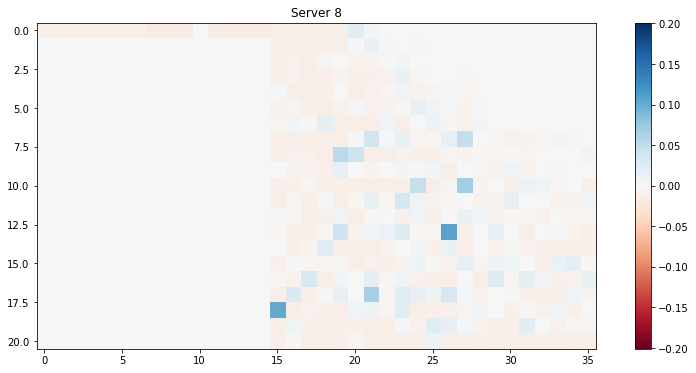

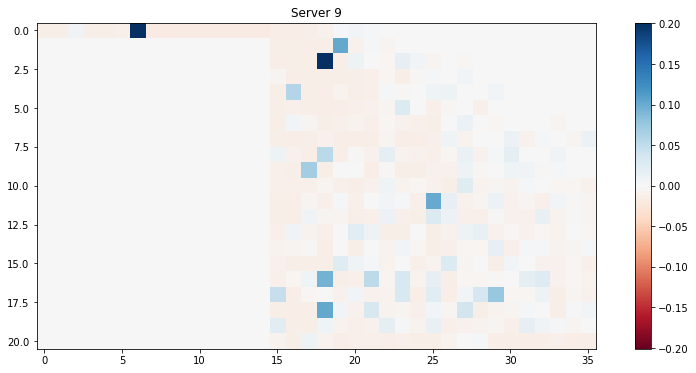

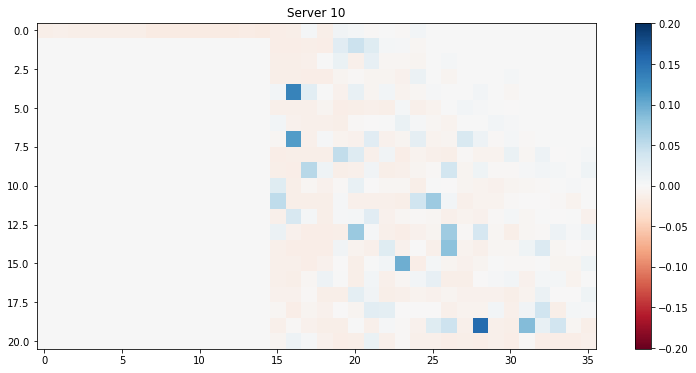

In [218]:
for srv_id in range(1, num_of_servers + 1):
    plt.figure(figsize=(14, 6))
    plt.title(f"Server {srv_id}")
    plt.imshow(all_diff_rates[srv_id - 1], cmap="RdBu")
    plt.colorbar()
    abs_max = np.max(np.abs(all_diff_rates[0]))
    plt.clim(-abs_max,abs_max)

## 1st Attempt

In this example the best utility that each server achieved are shown

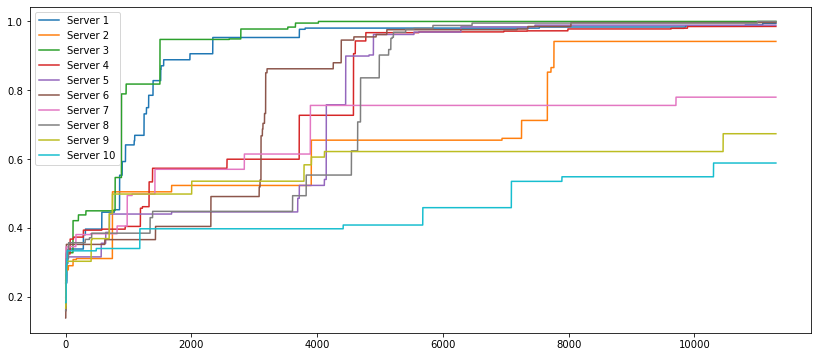

In [117]:
plt.figure(figsize=(14, 6))
for srv in range(num_of_servers):
    plt.plot([i[srv] for i in all_utilities])
plt.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])

# Servers analysis

In [214]:
print(f"ID \tSERVED \tBUSY TIME")
for srv in Q.nodes[2].servers:
    print(f"{srv.id_number} \t{len(srv.served_inds)} \t{round(srv.busy_time, 4)}")

ID 	SERVED 	BUSY TIME
1 	1 	9591.3446
2 	1 	9882.9512
3 	1 	9352.9319
4 	1 	9313.4733
5 	1 	9440.9055
6 	1 	9446.8648
7 	1 	9127.1042
8 	1 	9675.4449
9 	1 	9522.6484
10 	1 	9645.0266


In [132]:
all_diff_rates = []
for srv_id in range(1, num_of_servers + 1):
    diff_rates = np.zeros((buffer_capacity + 1, system_capacity + 1))
    for (u, v) in initial_rates[srv_id].keys():
        diff_rates[u, v] = rates[srv_id][(u,v)] - initial_rates[srv_id][(u,v)]
    all_diff_rates.append(diff_rates)

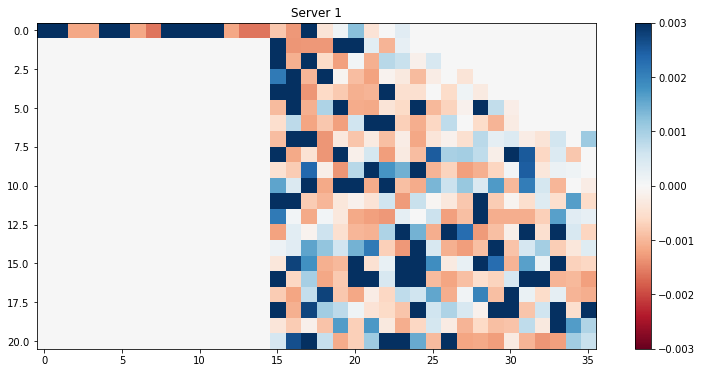

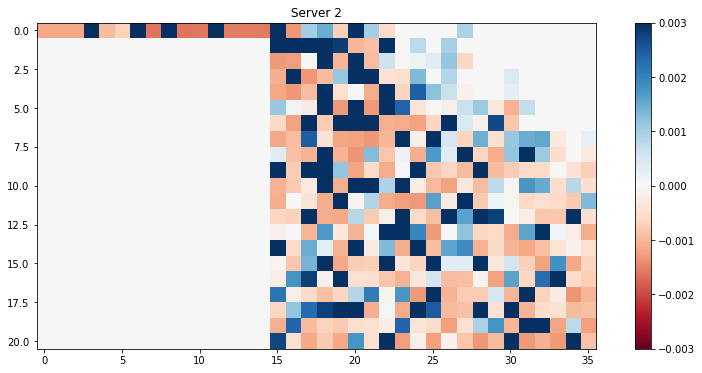

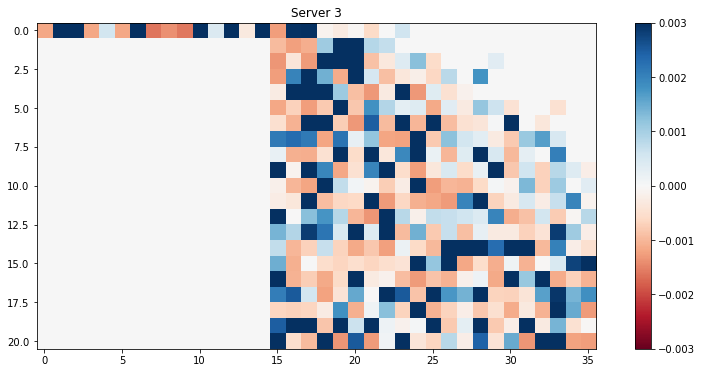

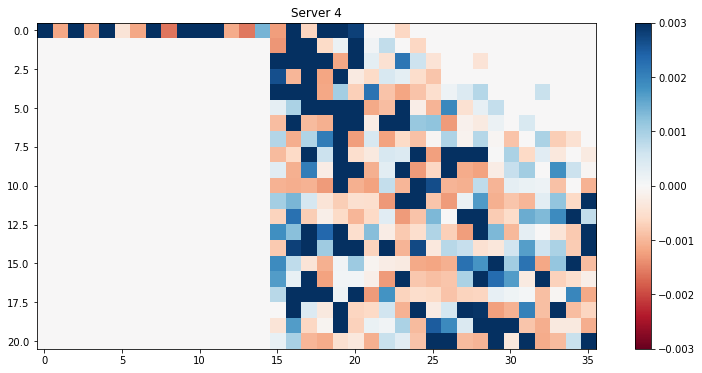

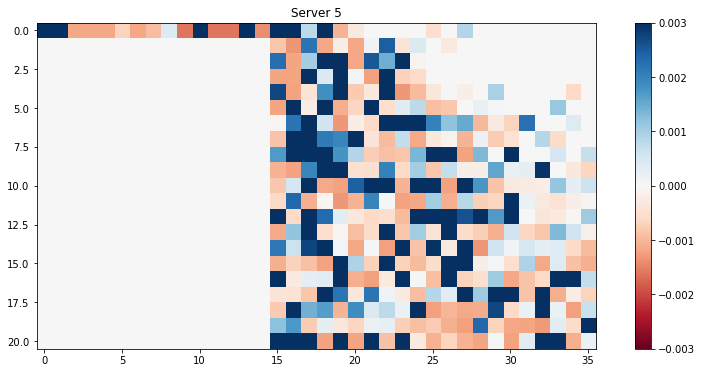

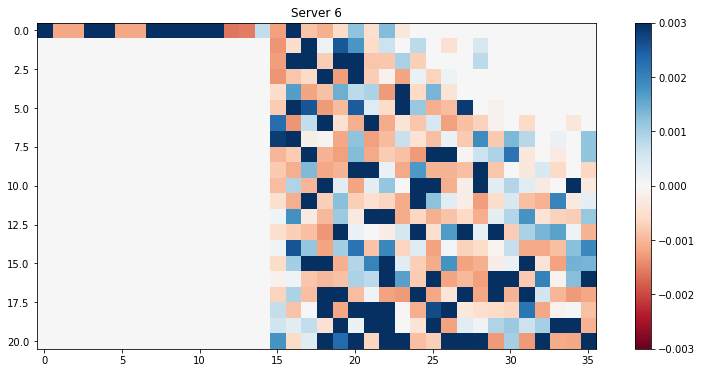

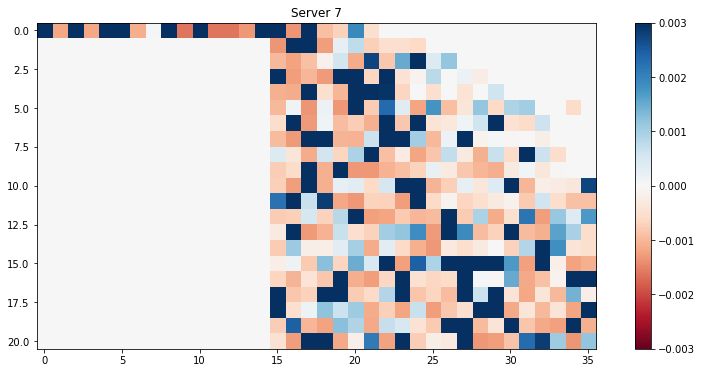

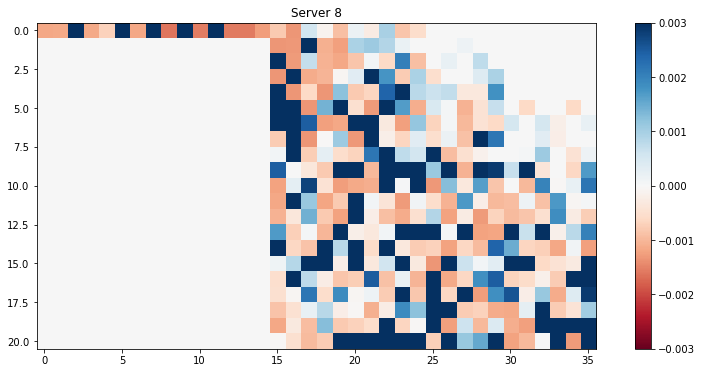

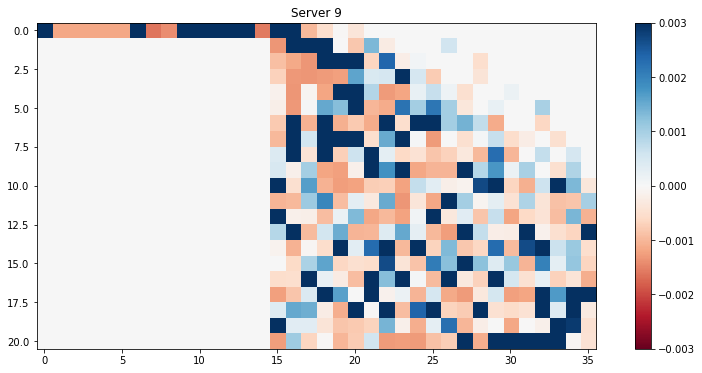

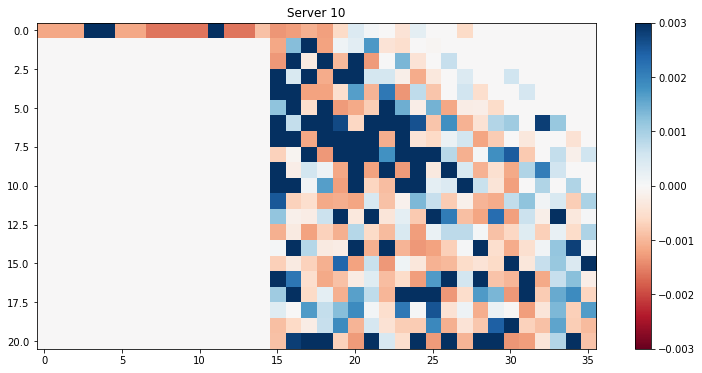

In [198]:
for srv_id in range(1, num_of_servers + 1):
    plt.figure(figsize=(14, 6))
    plt.title(f"Server {srv_id}")
    plt.imshow(all_diff_rates[srv_id - 1], cmap="RdBu")
    plt.colorbar()
    plt.clim(-0.003,0.003)